<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Sentiment%20Analysis%20with%20Transfer%20Learning%20and%20ONNX/Sentiment_Analysis_with_Transfer_Learning_and_ONNX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INSTALLATIONS AND IMPORTS**

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00


In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dropout, Input, Dense
from tensorflow.keras.models import Model
from datasets import load_dataset
from transformers import BertTokenizer, BertTokenizerFast, TFBertTokenizer, RobertaTokenizerFast
from transformers import DataCollatorWithPadding #Data Collator
from transformers import TFBertForSequenceClassification, TFBertModel, TFRobertaForSequenceClassification
from transformers import create_optimizer
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import ModelCheckpoint

# **DATASET PREPARATION**

In [3]:
dataset_id = "imdb"
dataset = load_dataset(dataset_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['train'][0:3]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

## **FOR BERT - BertTokenizerFast**

In [ ]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.is_fast

True

In [ ]:
test_input_1 = 'The Weather of Today is Gréat!'
test_input_2 = 'How are you doing?'
inputs = [test_input_1, test_input_2]

tokenizer.tokenize(inputs)

['the',
 'weather',
 'of',
 'today',
 'is',
 'great',
 '!',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [ ]:
tokenizer(inputs)

{'input_ids': [[101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 102], [101, 2129, 2024, 2017, 2725, 1029, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
tokenizer(test_input_1, test_input_2)
#token_type_ids signify sentence number a token belongs to for segment embedding

{'input_ids': [101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 102, 2129, 2024, 2017, 2725, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
output = tokenizer(inputs, padding = True, truncation = True, max_length = 128) #padding and truncation ensures all datapoints are of same sequence length
#token_id 0 is pad token here
#0 in attention_mask represents padding token here
output

{'input_ids': [[101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 102], [101, 2129, 2024, 2017, 2725, 1029, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0]]}

In [ ]:
tokenizer.decode(output['input_ids'])

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

In [ ]:
tokenizer.decode(output['input_ids'][0])

'[CLS] the weather of today is great! [SEP]'

In [ ]:
tokenizer.batch_decode(output['input_ids'])

['[CLS] the weather of today is great! [SEP]',
 '[CLS] how are you doing? [SEP] [PAD] [PAD]']

In [ ]:
output = tokenizer(inputs, padding = True, truncation = True, max_length = 7)

In [ ]:
tokenizer.decode(output['input_ids'][0]) #'great' and '!' is left out due to truncation

'[CLS] the weather of today is [SEP]'

In [ ]:
def preprocess(datapoint):
  return tokenizer(datapoint['text'], padding = True, truncation = True, max_length = 128)

In [ ]:
tokenized_dataset = dataset.map(preprocess, batched = True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
tokenized_dataset['train'][0:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

In [8]:
batch_size = 8

In [ ]:
#data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = "tf")

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = batch_size,
    #collate_fn = data_collator
)

In [ ]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = batch_size,
    #collate_fn = data_collator
)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

{'label': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 0, 1, 1, 0, 1, 1])>, 'input_ids': <tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[  101,  2358, 11589, ...,  2035,  2008,   102],
       [  101,  3565,  7986, ...,  2019,  2220,   102],
       [  101,  1001,  1001, ...,  2016,  1029,   102],
       ...,
       [  101,  1037,  2625, ...,  2082,  1005,   102],
       [  101,  2055,  1037, ...,  2033,  2000,   102],
       [  101,  4931,  2111, ...,  1045,  2428,   102]])>, 'token_type_ids': <tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 

In [ ]:
def swap_positions(dataset):
  return {'input_ids' : dataset['input_ids'],
          'token_type_ids' : dataset['token_type_ids'],
          'attention_mask' : dataset['attention_mask']}, dataset['label']

In [ ]:
tf_train_dataset = tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[  101,  4698,  1006, ...,  3828,  1996,   102],
       [  101,  1045,  2761, ..., 12064,  2135,   102],
       [  101, 12536,  2005, ...,  3560,  1998,   102],
       ...,
       [  101,  1026,  7987, ...,     0,     0,     0],
       [  101,  2012,  2034, ...,  2143,  3561,   102],
       [  101,  2061,  2009, ..., 11057, 11057,   102]])>, 'token_type_ids': <tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

## **FOR RoBERTa - RobertaTokenizerFast**

In [ ]:
model_id = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(datapoints):
  return tokenizer(datapoints["text"], padding = True, truncation = True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
tokenized_dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns = ['input_ids','attention_mask', 'label'],
    shuffle = True,
    batch_size = batch_size,
    #collate_fn=data_collator
)

In [ ]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns = ['input_ids','attention_mask', 'label'],
    shuffle = True,
    batch_size = batch_size,
    #collate_fn=data_collator
)

In [ ]:
def swap_positions(dataset):
  return {'input_ids' : dataset['input_ids'],
          'attention_mask' : dataset['attention_mask']}, dataset['label']

In [ ]:
tf_train_dataset = tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[    0,   113,  3609, ...,     1,     1,     1],
       [    0,   113, 25194, ...,     1,     1,     1],
       [    0,   448,   293, ...,     1,     1,     1],
       ...,
       [    0, 10169,   267, ...,     1,     1,     1],
       [    0,  2264,    10, ...,     1,     1,     1],
       [    0,  8346,     6, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([1, 0, 1, 0, 0, 1, 1, 0])>)


## **FOR XtremeDistil l12-h384 model id WITH TFBertTokenizerFast**

l is no. of layers and h is hidden size in model id

In [4]:
model_id = "microsoft/xtremedistil-l12-h384-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

In [5]:
def preprocess_function(datapoint):
  return tokenizer(datapoint["text"], max_length = 512, padding = True, truncation = True)

In [6]:
tokenized_dataset = dataset.map(preprocess_function, batched = True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [9]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = batch_size,
    #collate_fn = data_collator
)

In [10]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = batch_size,
    #collate_fn = data_collator
)

In [11]:
def swap_positions(dataset):
  return {'input_ids' : dataset['input_ids'],
          'token_type_ids' : dataset['token_type_ids'],
          'attention_mask' : dataset['attention_mask']}, dataset['label']

In [12]:
tf_train_dataset = tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [13]:
for i in tf_val_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[  101,  2728, 22304, ...,     0,     0,     0],
       [  101,  6583,  6776, ...,     0,     0,     0],
       [  101,  1045,  2228, ...,     0,     0,     0],
       ...,
       [  101,  2748,  2009, ...,     0,     0,     0],
       [  101,  2023,  2003, ...,     0,     0,     0],
       [  101,  7929,  1010, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

# **MODELLING**

## **TFBertForSequenceClassification**

In [ ]:
model_tfbert = TFBertForSequenceClassification.from_pretrained(model_id, num_labels = 2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_tfbert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **TFBertModel**

In [ ]:
model = TFBertModel.from_pretrained(model_id)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
input_ids = Input(shape = (512,), dtype = tf.int64, name = 'input_ids')
token_type_ids = Input(shape = (512,), dtype = tf.int64, name = 'token_type_ids')
attention_mask = Input(shape = (512,), dtype = tf.int64, name = 'attention_mask')

print(input_ids, token_type_ids, attention_mask)
x = model(input_ids = input_ids, token_type_ids = token_type_ids, attention_mask = attention_mask)
print(x)
x = Dense(128, activation = 'relu')(x[0][:, 0, :])
#x[0] denotes last_hidden_state and in that [:, 0, :] denotes the 0th token [CLS] for classification
output = Dense(1, activation = 'sigmoid', name = 'label')(x)

custom_bert = Model(inputs = [input_ids, token_type_ids, attention_mask], outputs = output)
custom_bert.summary()

## **TFRobertaForSequenceClassification**

In [ ]:
model_id = "roberta-base"

In [ ]:
model_roberta = TFRobertaForSequenceClassification.from_pretrained(model_id, num_labels = 2)
model_roberta.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **TFBertForSequenceClassification with XtremeDistil distillation**

In [14]:
model_id = "microsoft/xtremedistil-l12-h384-uncased"
model_xtremedistil = TFBertForSequenceClassification.from_pretrained(model_id, num_labels = 2)
model_xtremedistil.summary()

tf_model.h5:   0%|          | 0.00/134M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l12-h384-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  33360000  
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  770       
                                                                 
Total params: 33360770 (127.26 MB)
Trainable params: 33360770 (127.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **TRAINING**

In [15]:
model = model_xtremedistil

In [16]:
num_epochs = 10
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

In [17]:
optimizer, schedule = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = total_train_steps)

In [18]:
model.compile(#loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [21]:
checkpoint_filepath = '/content/sentiment_analysis_xtremedistil'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [22]:
history = model.fit(
    tf_train_dataset.take(100),
    validation_data = tf_val_dataset.take(20),
    epochs = num_epochs,
    callbacks = [model_checkpoint_callback])

Epoch 1/10
100/100 [==============================] - 121s 1s/step - loss: 0.3020 - accuracy: 0.8975 - val_loss: 0.3090 - val_accuracy: 0.8938
Epoch 2/10
100/100 [==============================] - 129s 1s/step - loss: 0.3108 - accuracy: 0.8775 - val_loss: 0.2354 - val_accuracy: 0.9125
Epoch 3/10
100/100 [==============================] - 123s 1s/step - loss: 0.2285 - accuracy: 0.9237 - val_loss: 0.2334 - val_accuracy: 0.9187
Epoch 4/10
100/100 [==============================] - 129s 1s/step - loss: 0.2396 - accuracy: 0.9100 - val_loss: 0.1457 - val_accuracy: 0.9500
Epoch 5/10
100/100 [==============================] - 50s 499ms/step - loss: 0.2167 - accuracy: 0.9200 - val_loss: 0.2027 - val_accuracy: 0.9187
Epoch 6/10
100/100 [==============================] - 50s 497ms/step - loss: 0.2330 - accuracy: 0.9100 - val_loss: 0.2346 - val_accuracy: 0.9187
Epoch 7/10
100/100 [==============================] - 51s 515ms/step - loss: 0.2230 - accuracy: 0.9175 - val_loss: 0.2201 - val_accuracy: 

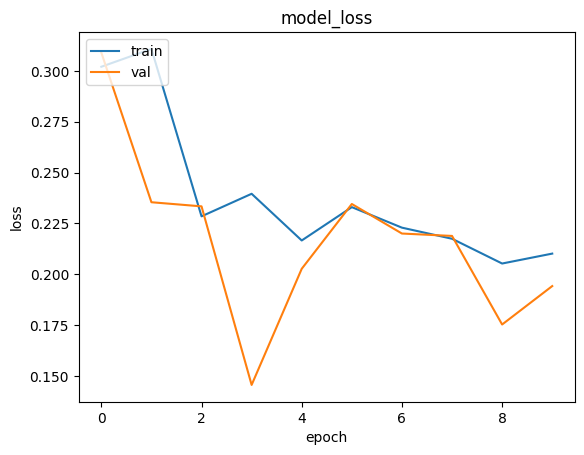

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

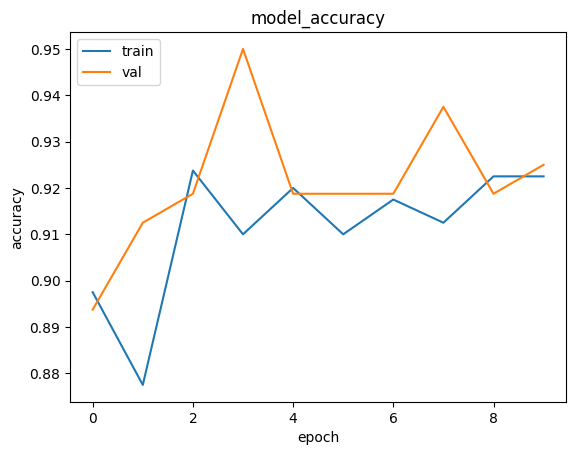

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# **TESTING**

In [25]:
inputs = tokenizer(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "],
                   padding = True, return_tensors = "tf")

logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[-0.780201    0.8299371 ]
 [-0.68765295  0.73368406]], shape=(2, 2), dtype=float32)


# **ONNX**

In [26]:
!pip install -U tf2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.6 MB/s eta 0:00:00


In [27]:
import onnxruntime as rt
import tf2onnx
rt.get_device()

'CPU'

In [28]:
output_path = "/content/xtremedistill.onnx"

In [29]:
spec = [tf.TensorSpec((None, 512), tf.int64, name = "input_ids"),
        tf.TensorSpec((None, 512), tf.int64, name = "token_type_ids"),
        tf.TensorSpec((None, 512), tf.int64, name = "attention_mask")]

model_proto, _ = tf2onnx.convert.from_keras(
    model, input_signature = spec,
    opset = 17, output_path = output_path,)
output_names = [n.name for n in model_proto.graph.output]

In [30]:
print(output_names)

['logits']


## **ONNX INFERENCE**

In [31]:
text=["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes!"]

inputs = tokenizer(text, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "np")

n_predictions = 1
print(inputs)

{'input_ids': array([[  101,  2023,  3185,  3504,  2200,  5875,  1010,  1045,  2293,
         1996,  2755,  2008,  1996,  5889,  2079,  1037,  2307,  3105,
         1999,  4760,  2129,  2111,  2973,  1999,  1996,  4985,  2301,
         1010,  2029,  2347,  1005,  1056,  2200,  2204,  2012,  2035,
         1012,  2021,  2012, 19738,  3367,  2023,  3185, 28667, 29313,
         2015,  2023,  5019,   999,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,

In [34]:
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers = providers)

t1 = time.time()
for _ in range(n_predictions):
  onnx_pred = m.run(["logits"], {'input_ids' : inputs['input_ids'],
                                'token_type_ids' : inputs['token_type_ids'],
                                'attention_mask' : inputs['attention_mask']})
print("Time for a single Prediction", (time.time() - t1) / n_predictions)

Time for a single Prediction 0.5018956661224365


In [35]:
print(onnx_pred)

[array([[-0.7802039,  0.8299405]], dtype=float32)]


## **BENCHMARK**

In [ ]:
tf, cpu = 600ms
tf, gpu = 130ms
tf_size = 50MB

onnx, cpu = 400ms
onnx, gpu = 8ms
onnx_size = 50MB
onnx_acc  = 91.9%

onnx_quantized, cpu = 190ms
onnx_quantized, gpu = 140ms
onnx_quantized_size = 13MB
onnx_quantized_acc  = 89.7%

## **DYNAMIC QUANTIZATION**

In [36]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [37]:
model_fp32 = '/content/xtremedistill.onnx'
model_quant = '/content/xtremedistill_quantized.onnx'

In [38]:
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

## **ACCURACY DROP DUE TO QUANTIZATION**

In [39]:
unbatched_val_dataset = tf_val_dataset.unbatch()

In [40]:
n_samples = 400

In [41]:
def accuracy(model):
  total = 0
  for text, label in unbatched_val_dataset.take(n_samples):

    onnx_pred = model.run(["logits"], {'input_ids' : [text['input_ids'].numpy()],
                                'token_type_ids' : [text['token_type_ids'].numpy()],
                                'attention_mask' : [text['attention_mask'].numpy()]})
    if np.argmax(onnx_pred, axis = -1)[0][0] == label.numpy():
      total += 1
  return (total / n_samples) * 100

In [44]:
providers=['CPUExecutionProvider']
m = rt.InferenceSession(model_fp32, providers = providers)
m_q = rt.InferenceSession(model_quant, providers = providers)
print(accuracy(m_q))
print(accuracy(m))

92.25
93.25
